In [1]:
%config IPCompleter.use_jedi = False

### Processing Pokemon Dataset from Kaggle

**Dataset link** - https://www.kaggle.com/thedagger/pokemon-generation-one
<br>This dataset has multiple images of each pokemon

In [2]:
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [3]:
p = Path("./Dataset/")
dirs = p.glob('*')
# for d in dirs:
#     print(d)
image_data = []
labels = []

#Optional
image_paths = []

label_dict = {"Pikachu":0, "Bulbasaur":1, "Meowth":2}
label2pokemon = {0:"Pikachu", 1:"Bulbasaur", 2:"Meowth"}

for folder_dir in dirs:
    # print(str(folder_dir).split("\\")[-1])
    label = str(folder_dir).split("\\")[-1]
    cnt=0
    print(folder_dir)
    
    #Iterate over folder_dir and pick all images of the pokemon
    for img_path in folder_dir.glob("*.jpg"):
        img = image.load_img(img_path, target_size=(40,40))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(label_dict[label])
        cnt += 1
        
    print(cnt)

Dataset\Bulbasaur
176
Dataset\Meowth
70
Dataset\Pikachu
199


### Visualisation

In [4]:
import numpy as np

In [5]:
print(len(image_data))
print(len(labels))

445
445


In [6]:

# print(labels)

In [7]:
X = np.array(image_data)
Y = np.array(labels)

print(X.shape)
print(Y.shape)

(445, 40, 40, 3)
(445,)


In [8]:
import random
random.seed(10)

In [9]:
#@ Shuffle the data
from sklearn.utils import shuffle
X,Y = shuffle(X,Y,random_state=2)

# Normalisation
X = X/255.0

In [10]:
X[0].shape

(40, 40, 3)

In [11]:
# Draw some pokemons
def drawImg(img, label):
    plt.title(label2pokemon[label])
    plt.imshow(img)
    plt.style.use("seaborn")
    plt.axis("off")
    plt.show()

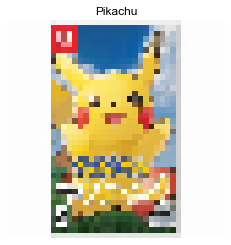

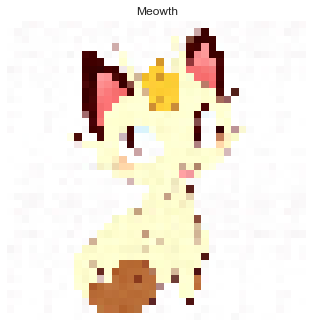

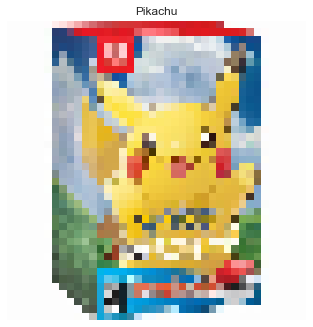

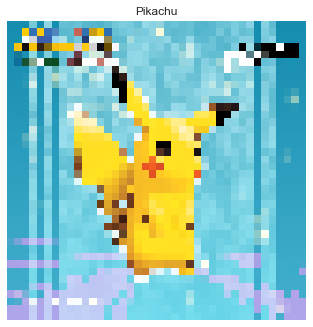

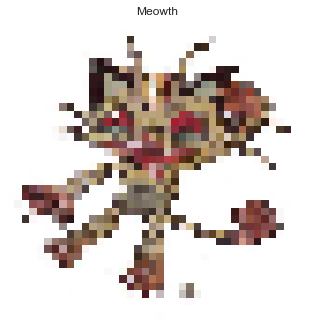

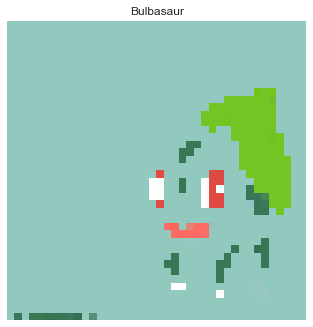

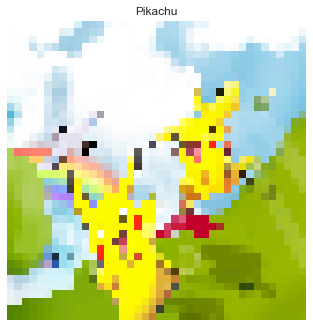

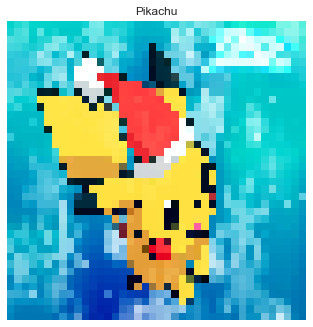

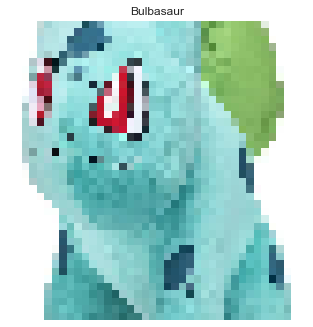

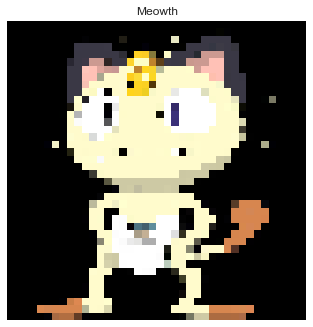

In [12]:
for i in range(10):
    drawImg(X[i].reshape(40,40,3),Y[i])

### Split into train and test set

In [13]:
split = int(X.shape[0]*0.8)

X_ = np.array(X)
Y_ = np.array(Y)

# Training Set
X = X_[:split,:]
Y = Y_[:split]

# Test Set
XTest = X_[split:,:]
YTest = Y_[split:]

print(X.shape, Y.shape)
print(XTest.shape, YTest.shape)

(356, 40, 40, 3) (356,)
(89, 40, 40, 3) (89,)


### Neural Network implementation

In [14]:
class Neural_Network:
    def __init__(self, input_size, layers, output_size):
        np.random.seed(0)
        
        model = {} #dictionary
        
        # First Hidden Layer
        model['W1'] = np.random.randn(input_size, layers[0])
        model['b1'] = np.zeros((1,layers[0]))
        
        # Second Hidden Layer
        model['W2'] = np.random.randn(layers[0], layers[1])
        model['b2'] = np.zeros((1,layers[1]))
        
        # Output Layer
        model['W3'] = np.random.randn(layers[1], output_size)
        model['b3'] = np.zeros((1,output_size))
        
        self.model = model
        
    def forward(self, x):
        
        W1, W2, W3 = self.model['W1'], self.model['W2'], self.model['W3']
        b1, b2, b3 = self.model['b1'], self.model['b2'], self.model['b3']
        
        z1 = np.dot(x,W1) + b1
        a1 = np.tanh(z1) # This activation function provide values in range of (-1,1)
        
        z2 = np.dot(a1, W2) + b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2, W3) + b3
        y_ = softmax(z3)
        
        self.activation_outputs = (a1,a2,y_)
        return y_
        
    def backward(self, x , y, learning_rate=0.001):
        
        W1, W2, W3 = self.model['W1'], self.model['W2'], self.model['W3']
        b1, b2, b3 = self.model['b1'], self.model['b2'], self.model['b3']
        m = x.shape[0]
        
        a1,a2,y_ = self.activation_outputs
        
        delta3 = y_ - y
        dw3 = np.dot(a2.T, delta3)
        db3 = np.sum(delta3, axis=0)
        
        delta2 = (1-np.square(a2))*np.dot(delta3, W3.T)
        # becuase derivative of tanh(x) = 1-(tanh(x))^2 and a2 = tanh
        dw2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0)
        
        delta1 = (1-np.square(a1))*np.dot(delta2, W2.T)
        dw1 = np.dot(x.T, delta1)
        db1 = np.sum(delta1, axis=0)
        
        # Update model parameters using gradient descent
        self.model["W1"] -= learning_rate*dw1
        self.model["b1"] -= learning_rate*db1
        
        self.model["W2"] -= learning_rate*dw2
        self.model["b2"] -= learning_rate*db2
        
        self.model["W3"] -= learning_rate*dw3
        self.model["b3"] -= learning_rate*db3
        
        # :)
        
    def predict(self, x):
        y_out = self.forward(x)
        return np.argmax(y_out, axis=1)
    
    def summary(self):
        W1, W2, W3 = self.model['W1'], self.model['W2'], self.model['W3']
        a1, a2, y_ = self.activation_outputs
        
        print("W1 ", W1.shape)
        print("A1 ", a1.shape)
        
        print("W2 ", W2.shape)
        print("A2 ", a2.shape)
        
        print("W3 ", W3.shape)
        print("Y_ ", y_.shape)
        
def softmax(a):
    e_pa = np.exp(a) # Vector
    ans = e_pa/np.sum(e_pa, axis=1, keepdims=True) 
    #Keep dims maintains the dimensions of the original array
    return ans

In [15]:
def loss(y_oht, p):
    # y_oht means one hot key encoded y_ and p means probabilities
    l = -np.mean(y_oht*np.log(p))
    return l

def one_hot(y, depth):
    m = y.shape[0]
    y_oht = np.zeros((m,depth))
    y_oht[np.arange(m),y] = 1
    return y_oht

In [16]:
def train(X,Y,model,epochs,learning_rate,logs=True):
    training_loss = []
    
    classes = len(np.unique(Y))
    Y_OHT = one_hot(Y, classes)
    
    for ix in range(epochs):
        Y_ = model.forward(X)
        l = loss(Y_OHT, Y_)
        training_loss.append(l)
        model.backward(X,Y_OHT,learning_rate)
        
        if(logs):
            print("Epoch %d Loss %.4f"%(ix,l))
    return training_loss

### Training the model

In [17]:
X = X.reshape(X.shape[0],-1)
print(X.shape)

XTest = XTest.reshape(XTest.shape[0],-1)
print(XTest.shape)

(356, 4800)
(89, 4800)


In [18]:
model = Neural_Network(input_size=4800, layers=[100,50], output_size=3)

In [19]:
l = train(X,Y,model,500,0.0002)

Epoch 0 Loss 3.1889
Epoch 1 Loss 2.4373
Epoch 2 Loss 1.7468
Epoch 3 Loss 1.4452
Epoch 4 Loss 1.2624
Epoch 5 Loss 1.1441
Epoch 6 Loss 1.1098
Epoch 7 Loss 0.9812
Epoch 8 Loss 0.9642
Epoch 9 Loss 0.8528
Epoch 10 Loss 0.8033
Epoch 11 Loss 0.7348
Epoch 12 Loss 0.7104
Epoch 13 Loss 0.7228
Epoch 14 Loss 0.6546
Epoch 15 Loss 0.6419
Epoch 16 Loss 0.5684
Epoch 17 Loss 0.5362
Epoch 18 Loss 0.5569
Epoch 19 Loss 0.5118
Epoch 20 Loss 0.4834
Epoch 21 Loss 0.4100
Epoch 22 Loss 0.4671
Epoch 23 Loss 0.4647
Epoch 24 Loss 0.4538
Epoch 25 Loss 0.3971
Epoch 26 Loss 0.3755
Epoch 27 Loss 0.3605
Epoch 28 Loss 0.3915
Epoch 29 Loss 0.3463
Epoch 30 Loss 0.3257
Epoch 31 Loss 0.3022
Epoch 32 Loss 0.3034
Epoch 33 Loss 0.2924
Epoch 34 Loss 0.2864
Epoch 35 Loss 0.2956
Epoch 36 Loss 0.2717
Epoch 37 Loss 0.2503
Epoch 38 Loss 0.2735
Epoch 39 Loss 0.2478
Epoch 40 Loss 0.2450
Epoch 41 Loss 0.2631
Epoch 42 Loss 0.2497
Epoch 43 Loss 0.2256
Epoch 44 Loss 0.2174
Epoch 45 Loss 0.2303
Epoch 46 Loss 0.2265
Epoch 47 Loss 0.2058
Ep

Epoch 382 Loss 0.0266
Epoch 383 Loss 0.0267
Epoch 384 Loss 0.0266
Epoch 385 Loss 0.0269
Epoch 386 Loss 0.0263
Epoch 387 Loss 0.0259
Epoch 388 Loss 0.0257
Epoch 389 Loss 0.0256
Epoch 390 Loss 0.0257
Epoch 391 Loss 0.0253
Epoch 392 Loss 0.0253
Epoch 393 Loss 0.0253
Epoch 394 Loss 0.0251
Epoch 395 Loss 0.0250
Epoch 396 Loss 0.0249
Epoch 397 Loss 0.0249
Epoch 398 Loss 0.0248
Epoch 399 Loss 0.0248
Epoch 400 Loss 0.0247
Epoch 401 Loss 0.0248
Epoch 402 Loss 0.0257
Epoch 403 Loss 0.0300
Epoch 404 Loss 0.0247
Epoch 405 Loss 0.0249
Epoch 406 Loss 0.0251
Epoch 407 Loss 0.0261
Epoch 408 Loss 0.0240
Epoch 409 Loss 0.0240
Epoch 410 Loss 0.0241
Epoch 411 Loss 0.0238
Epoch 412 Loss 0.0237
Epoch 413 Loss 0.0238
Epoch 414 Loss 0.0235
Epoch 415 Loss 0.0234
Epoch 416 Loss 0.0234
Epoch 417 Loss 0.0233
Epoch 418 Loss 0.0234
Epoch 419 Loss 0.0232
Epoch 420 Loss 0.0231
Epoch 421 Loss 0.0231
Epoch 422 Loss 0.0233
Epoch 423 Loss 0.0230
Epoch 424 Loss 0.0229
Epoch 425 Loss 0.0230
Epoch 426 Loss 0.0227
Epoch 427 

### Visualising the loss with number of epoch

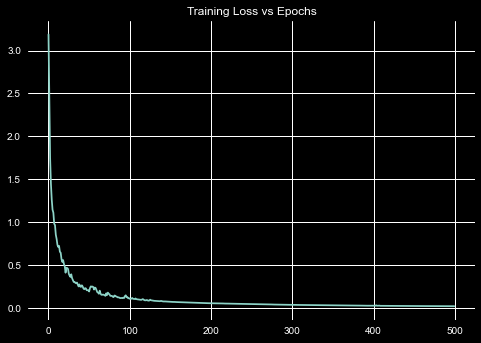

In [21]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")
plt.title("Training Loss vs Epochs")
plt.plot(l)

plt.show()

### Finding Accuracy

In [23]:
def getAccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc

print("Train acc %.4f"%getAccuracy(X,Y,model))
print("Test Acc %.4f"%getAccuracy(XTest,YTest,model))

Train acc 0.9888
Test Acc 0.6742


### Visualising the results

In [28]:
from sklearn.metrics import confusion_matrix

In [39]:
from visualize import plot_confusion_matrix

In [40]:
outputs = model.predict(X)
cnf_matrix = confusion_matrix(outputs,Y)
print(cnf_matrix)

[[158   0   1]
 [  1 135   1]
 [  1   0  59]]


[[158   0   1]
 [  1 135   1]
 [  1   0  59]]
Confusion matrix, without normalization


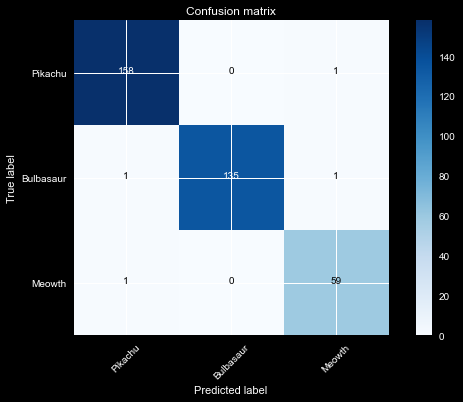

In [43]:
plot_confusion_matrix(cnf_matrix, classes=["Pikachu", "Bulbasaur", "Meowth"])

In [24]:
from sklearn.metrics import classification_report

In [27]:
print(classification_report(outputs,Y))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       159
           1       1.00      0.99      0.99       137
           2       0.97      0.98      0.98        60

    accuracy                           0.99       356
   macro avg       0.98      0.99      0.99       356
weighted avg       0.99      0.99      0.99       356



In [45]:
test_outputs = model.predict(XTest)
print(classification_report(test_outputs,YTest))

              precision    recall  f1-score   support

           0       0.72      0.67      0.69        42
           1       0.68      0.82      0.75        34
           2       0.44      0.31      0.36        13

    accuracy                           0.67        89
   macro avg       0.62      0.60      0.60        89
weighted avg       0.66      0.67      0.66        89



[[28 11  3]
 [ 4 28  2]
 [ 7  2  4]]
Confusion matrix, without normalization


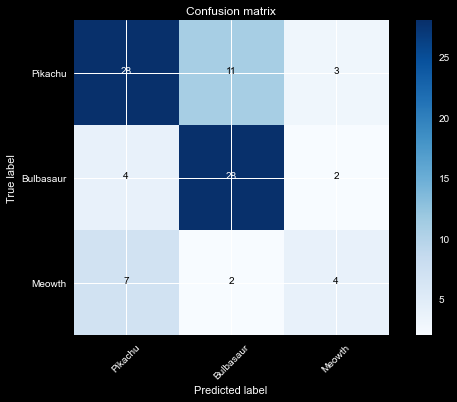

In [46]:
cnf_matrix = confusion_matrix(test_outputs,YTest)
plot_confusion_matrix(cnf_matrix, classes=["Pikachu", "Bulbasaur", "Meowth"])

### Visualize Misclassifications

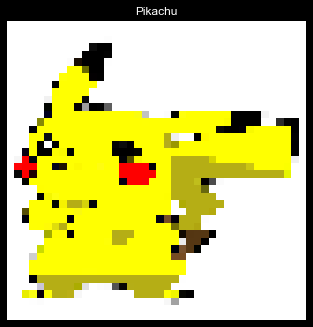

Prediction 76 Meowth


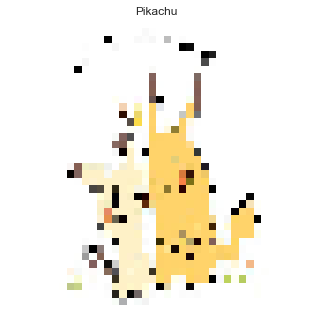

Prediction 132 Bulbasaur


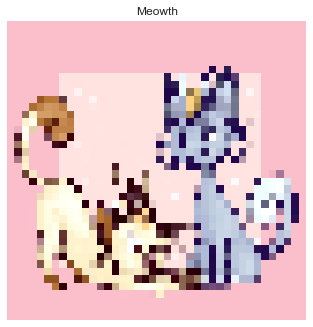

Prediction 161 Pikachu


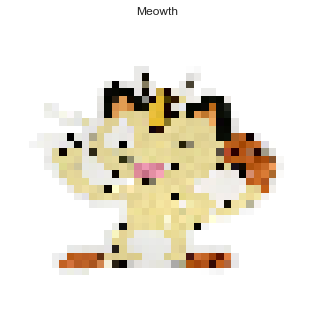

Prediction 321 Bulbasaur


In [47]:
for i in range(Y.shape[0]):
    if Y[i]!=outputs[i]:
        drawImg(X[i].reshape(40,40,3),Y[i])
        print("Prediction %d %s"%(i,label2pokemon[outputs[i]]))